In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from rdkit.Chem import AllChem
import rdkit
Chem = rdkit.Chem
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator

from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [4]:
baseall = pd.read_csv('./data/filtered_BACE_inhibitors.csv')

In [5]:
baseall.head()

,ChEMBL ID,IC50,Smiles,Unit,pIC50,active
0,CHEMBL247416,2.0,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...,nM,8.70,1.0
1,CHEMBL429477,66.0,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...,nM,7.18,1.0
2,CHEMBL393850,279.0,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...,nM,6.55,1.0
3,CHEMBL1546,100000.0,CC(N)Cc1ccc(O)cc1,nM,4.00,0.0
4,CHEMBL502753,1000.0,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...,nM,6.00,0.0


In [6]:
baseall.isna().sum()

ChEMBL ID    0
IC50         0
Smiles       0
Unit         0
pIC50        0
active       0
dtype: int64

#### Convert Smiles into Morgan fingerprints

In [35]:
#https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html

def smiles_to_fp(smiles, radius = 2, nBits = 1024, reshape_size = None):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2, nBits = nBits)
    fp_array = np.array(fp, dtype = np.int)
    if reshape_size is None:
        side_length = int(math.sqrt(nBits))
        if side_length * side_length != nBits:
            raise ValueError("nBits should be perfect square when reshape is not specified.")
        reshape_size = (side_length, side_length)
    try:
        fp_2d = fp_array.reshape(reshape_size)
    except ValueError as e:
        raise (f"cannot reshape array of size {nBits} into shape {reshape_size}.Error: {e}")
    
    return fp_2d

In [36]:
baseall['fp'] = baseall['Smiles'].apply(smiles_to_fp)
baseall.head(1)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [32]:
fp = baseall['fp']

#### Reshape fingerprints 1D to 2D

In [33]:
fp_array = np.array(fp)
print(fp_array.size)

7339


In [ ]:
fp_2d = fp_array.reshape((-1,1,32,32))

##### Split the data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2024)

In [92]:
x_train.shape, x_test.shape

((5137,), (2202,))

In [1]:
# fingerprint dimensions
fingerprint_length = 167
num_samples = 5137

#### CNN model

In [94]:
model = Sequential([
    Conv1D(32, 3, activation = 'relu', input_shape = (167, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation = 'relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

C:\Users\mudep\anaconda3\envs\my-rdkit-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [95]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 165, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 82, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 80, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,305 (665.25 KB)

 Trainable params: 170,305 (665.25 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
model.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam',
    metrics = ['mse', 'mae']
)

In [97]:
# Fit!
history = model.fit(
    np.array(list((x_train))).astype(float), y_train.values,
    validation_data = (np.array(list((x_test))).astype(float), y_test.values),
    epochs = 100,
)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1736 - mae: 1.9037 - mse: 7.1737 - val_loss: 1.4046 - val_mae: 0.9596 - val_mse: 1.4051
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3875 - mae: 0.9560 - mse: 1.3876 - val_loss: 1.1495 - val_mae: 0.8615 - val_mse: 1.1501
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1650 - mae: 0.8588 - mse: 1.1650 - val_loss: 1.0978 - val_mae: 0.8406 - val_mse: 1.0985
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0947 - mae: 0.8325 - mse: 1.0947 - val_loss: 1.0495 - val_mae: 0.8083 - val_mse: 1.0504
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0090 - mae: 0.7894 - mse: 1.0090 - val_loss: 1.0133 - val_mae: 0.8023 - val_mse: 1.0141
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9766 - mae: 0.7787 - mse: 0.9766 - val_loss: 1.0132 - val_mae: 0.7950 - val_mse: 1.0139
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9047 - mae: 0.7551 - mse: 0.904

##### Loss plots

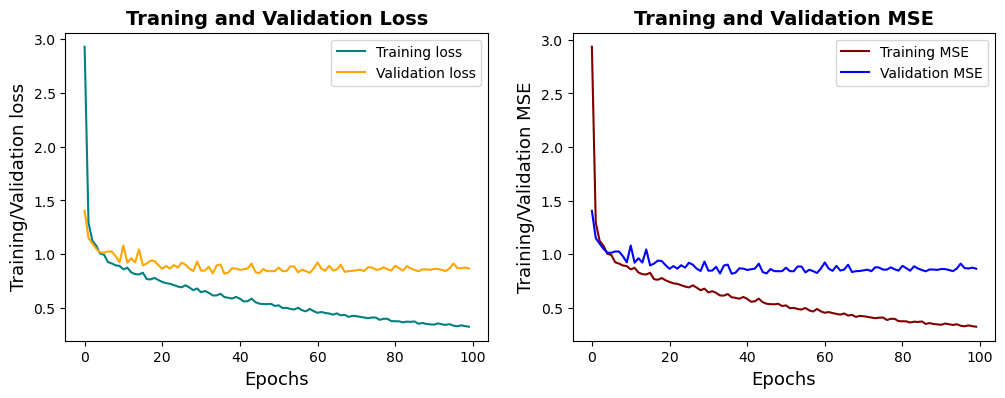

In [98]:
fig, axs = plt.subplots(1,2, figsize = (12, 4))

axs[0].plot(history.history['loss'], c = 'teal', label = 'Training loss')
axs[0].plot(history.history['val_loss'], c = 'orange', label = 'Validation loss')
axs[0].set_xlabel('Epochs', fontsize = 13)
axs[0].set_title('Traning and Validation Loss', fontweight="bold", fontsize = 14)
axs[0].set_ylabel('Training/Validation loss', fontsize = 13)
axs[1].plot(history.history['mse'], c = 'maroon', label = 'Training MSE')
axs[1].plot(history.history['val_mse'], c = 'blue', label = 'Validation MSE')
axs[1].set_xlabel('Epochs', fontsize = 13)
axs[1].set_ylabel('Training/Validation MSE', fontsize = 13)
axs[1].set_title('Traning and Validation MSE', fontweight="bold", fontsize = 14)
axs[0].legend()
axs[1].legend();

##### Evaluate the model

In [99]:
# Evaluate the model
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

 loss: 0.86
 mse (same as loss): 0.71
 mae: 0.86


##### Predict pIC50 values (y_preds) for x_train and x_test data

In [100]:
y_train_pred = model.predict(np.array(list((x_train))))

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [101]:
y_test_pred = model.predict(np.array(list((x_test))))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


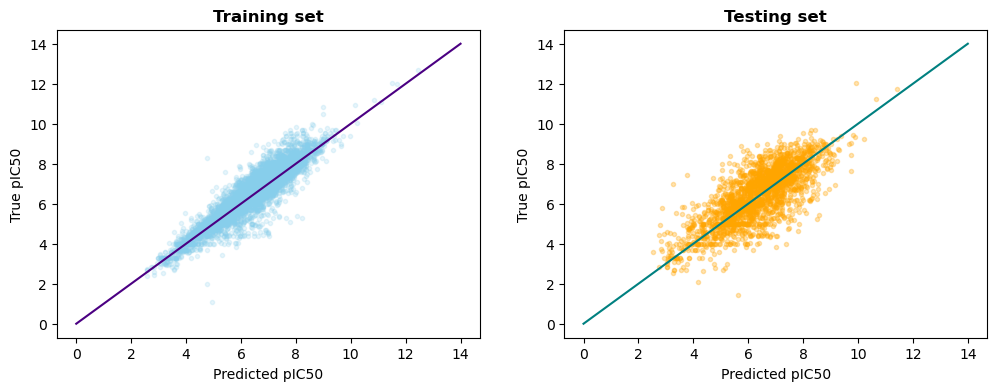

In [102]:
fig, axs = plt.subplots(1,2, figsize = (12, 4))
limits = 0, 14
lin = np.linspace(*limits, 100)

axs[0].scatter(y_train_pred, y_train, marker = '.', color = 'skyblue', alpha = 0.2)
axs[0].set_xlabel('Predicted pIC50')
axs[0].set_ylabel('True pIC50')
axs[0].set_title('Training set', fontweight="bold")
axs[0].plot(lin, lin, color = 'indigo')
axs[1].scatter(y_test_pred, y_test, marker = '.', color = 'orange', alpha = 0.3)
axs[1].set_xlabel('Predicted pIC50')
axs[1].set_ylabel('True pIC50')
axs[1].set_title('Testing set', fontweight="bold")
axs[1].plot(lin, lin, color = 'teal');

In [107]:
metrics.r2_score(y_train, y_train_pred)

0.8415235303072214

In [108]:
metrics.r2_score(y_test, y_test_pred)

0.5531839385849031

In [109]:
metrics.mean_squared_error(y_train, y_train_pred)

0.3047188527987592

In [110]:
metrics.mean_squared_error(y_test, y_test_pred)

0.8649034526482364

#### Predict pIC50 values for BACE1 target from list of approved drugs

In [111]:
approved = pd.read_csv('./data/approved.csv')

In [112]:
approved.head(2)

,ChEMBL ID,IC50,Unit,Smiles,pIC50
0,CHEMBL1640,13.0,nM,Cc1cc(-c2ccc(/N=N/c3c(S(=O)(=O)[O-])cc4cc(S(=O...,7.89
1,CHEMBL1201033,4.0,nM,CN(C)/C=N/c1c(I)cc(I)c(CCC(=O)[O-])c1I.[Na+],8.40


#### Convert Smiles to fingerprints

In [113]:
approved['fingerprints'] = approved['Smiles'].apply(smiles_to_fp)

In [114]:
approved.head(2)

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fingerprints
0,CHEMBL1640,13.0,nM,Cc1cc(-c2ccc(/N=N/c3c(S(=O)(=O)[O-])cc4cc(S(=O...,7.89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL1201033,4.0,nM,CN(C)/C=N/c1c(I)cc(I)c(CCC(=O)[O-])c1I.[Na+],8.40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [115]:
approved.shape

(2052, 6)

In [116]:
approved_predictions =  model.predict(np.array(list((approved['fingerprints']))).astype(float))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [117]:
predicted_pIC50 = pd.DataFrame(approved_predictions, columns = ['BACE1_pIC50'])

predicted_base_pIC50_df = approved.join(predicted_pIC50)

In [118]:
predicted_base_pIC50_df.sample(3)

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fingerprints,BACE1_pIC50
948,CHEMBL632,820.0,nM,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,6.09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.252836
398,CHEMBL1029,221.0,nM,CCCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO,6.66,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.496982
247,CHEMBL908,92.0,nM,CN(C)CC/C=C1/c2ccccc2Sc2ccc(Cl)cc21,7.04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.821145


#### Save predictions

In [119]:
predicted_base_pIC50_df.to_csv('./data/approved_BACE_predicts')

##### Select bottom 5 drugs

In [120]:
predicted_base_pIC50_df = predicted_base_pIC50_df.sort_values(by='BACE1_pIC50', ascending = True)

In [121]:
# bottom 5 molecules
bottom5_drugs = predicted_base_pIC50_df[-5:]
bottom5_drugs

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fingerprints,BACE1_pIC50
2013,CHEMBL3545058,2.0,nM,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...,8.70,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.370330
1006,CHEMBL2103877,13.0,nM,C=C1CCN([C@H](C)[C@](O)(Cn2cncn2)c2ccc(F)cc2F)CC1,7.89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.457076
1559,CHEMBL4066936,50.0,nM,COC(=O)Nc1c(N)nc(-c2nn(Cc3ccccc3F)c3ncc(F)cc23...,7.30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.817651
338,CHEMBL1201206,1.0,nM,CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C...,9.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.915836
1098,CHEMBL1358,397.0,nM,C[C@]12CC[C@@H]3c4ccc(O)cc4C[C@@H](CCCCCCCCC[S...,6.40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.010485


#### Visualize bottom 5 molecules

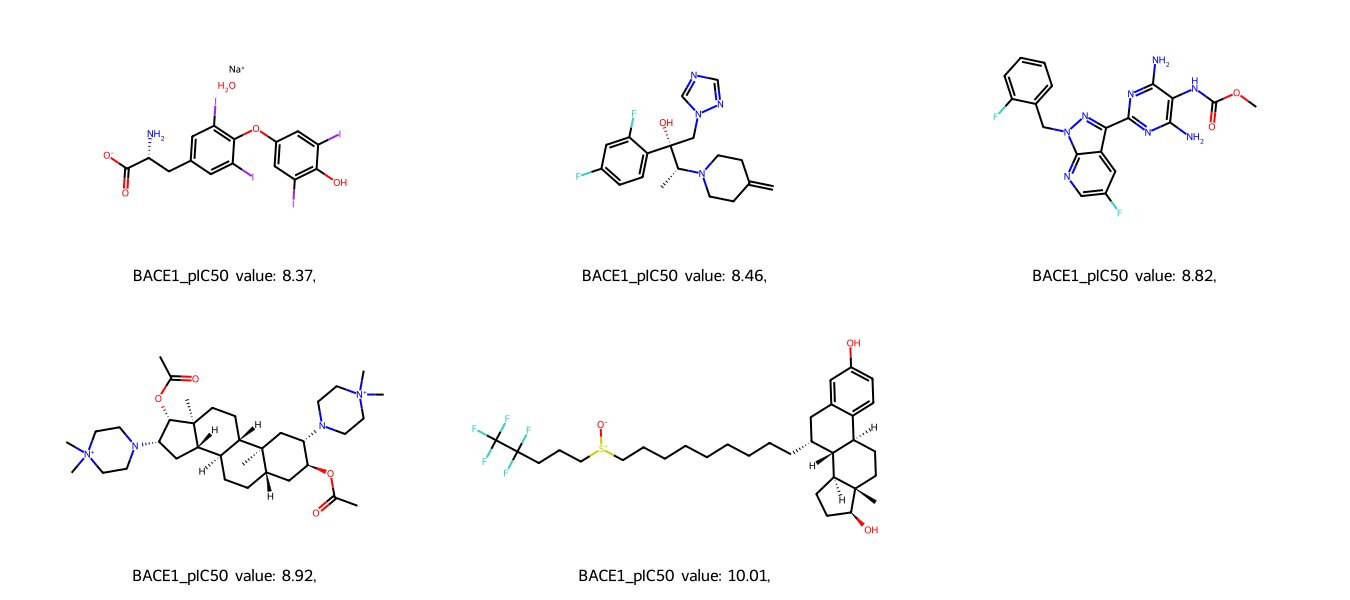

In [122]:
bottom5_drugs_pIC50 = predicted_base_pIC50_df['Smiles'][bottom5_drugs.index]

mols_base = [Chem.MolFromSmiles(smile) for smile in bottom5_drugs_pIC50]
pIC50_base = bottom5_drugs['BACE1_pIC50'].tolist()
pIC50_values = [(f"BACE1_pIC50 value: {value:.2f},")  for value in pIC50_base]
Draw.MolsToGridImage(mols_base, molsPerRow = 3, subImgSize=(450, 300), legends = pIC50_values)

##### Select top 5 drugs

In [126]:
#Top molecules are very small, so left first 200
top5_drugs = predicted_base_pIC50_df[300:305]
top5_drugs

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fingerprints,BACE1_pIC50
1387,CHEMBL1200585,651.0,nM,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,6.19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.430296
1708,CHEMBL1201731,10.0,nM,Cl.OC(CNCC(O)C1CCc2cc(F)ccc2O1)C1CCc2cc(F)ccc2O1,8.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.431327
214,CHEMBL1614,25.0,nM,C[C@H]1O[C@@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,7.60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.435114
1691,CHEMBL1201037,7.0,nM,Cl.NCCCC(N)(C(=O)O)C(F)F.O,8.15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.435494
1055,CHEMBL1104,36.0,nM,CC[N+](C)(C)c1cccc(O)c1,7.44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.441624


##### Visualize top5 molecules

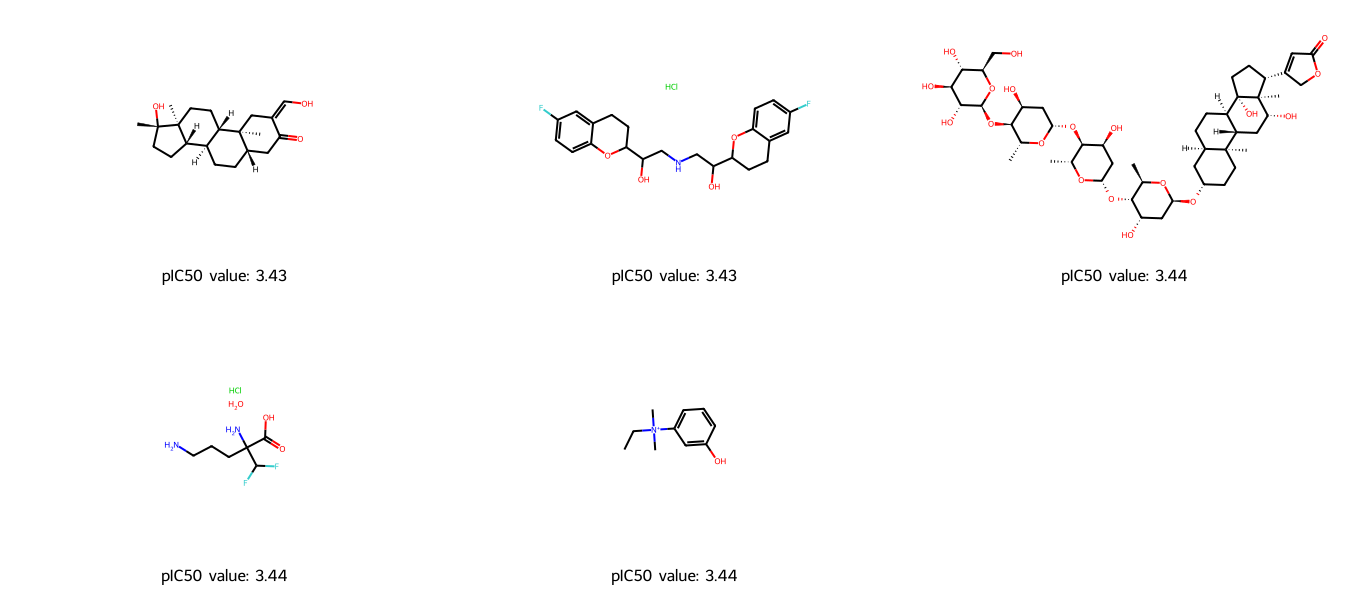

In [127]:
top5_pIC50 = predicted_base_pIC50_df['Smiles'][top5_drugs.index]
mols_base = [Chem.MolFromSmiles(smile) for smile in top5_pIC50]
pIC50_base = top5_drugs['BACE1_pIC50'].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_base]
Draw.MolsToGridImage(mols_base, molsPerRow = 3, subImgSize=(450, 300), legends=pIC50_values)

In [38]:
top_bottom_drugs = pd.concat([top5_drugs, bottom5_drugs], axis = 0)

In [39]:
top_bottom_drugs

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fingerprints,BACE1_pIC50
990,CHEMBL529437,21.0,nM,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,7.68,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0...,3.603276
420,CHEMBL3317857,273.0,nM,O=C(O)C[C@@H]1CC[C@H](NC(=O)Cc2cccs2)B(O)O1,6.56,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0...,3.606456
341,CHEMBL1501,316.0,nM,CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@...,6.50,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,3.609091
1387,CHEMBL1200585,651.0,nM,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,6.19,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,3.611792
267,CHEMBL956,99.0,nM,CC(C(=O)O)c1ccc(C(=O)c2cccs2)cc1,7.00,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,3.619000
572,CHEMBL2105759,428.0,nM,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,6.37,[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0...,9.049152
1998,CHEMBL1568276,31.0,nM,CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC...,7.51,[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0...,9.060800
1823,CHEMBL1596,3.0,nM,CC1(C)S[C@@H]2[C@H](NC(=O)C(C(=O)Oc3ccc4c(c3)C...,8.52,[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0...,9.150239
1695,CHEMBL1443,190.0,nM,CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC...,6.72,[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0...,10.206233
526,CHEMBL73234,96.0,nM,CCN(CC)CCOCCOC(=O)C1(c2ccccc2)CCCC1,7.02,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,10.427003


##### Save for docking onto the BASE1 structure

In [41]:
top_bottom_drugs.to_csv('./data/approved_BASE_docking.csv')